In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [4]:
# Importing the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import pandas as pd
import os
import pickle
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2678784/45929032 bytes (5.8%)5627904/45929032 bytes (12.3%)8683520/45929032 bytes (18.9%)11862016/45929032 bytes (25.8%)14573568/45929032 bytes (31.7%)17571840/45929032 bytes (38.3%)20234240/45929032 bytes (44.1%)23191552/45929032 bytes (50.5%)26025984/45929032 bytes (56.7%)28655616/45929032 bytes (62.4%)31375360/45929032 bytes (68.3%)34160640/45929032 bytes (74.4%)

In [5]:
seed_constant = 42
np.random.seed(seed_constant)

random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

robbery_GD_path='/content/drive/MyDrive/Data298b_robbery/Training/Robbery'
normal_GD_path='/content/drive/MyDrive/Data298b_robbery/Training/Normal'
robbery_dir = os.listdir(robbery_GD_path)
normal_dir=os.listdir(normal_GD_path)


<Figure size 1440x1440 with 0 Axes>

In [7]:
print(len(robbery_dir))
print(len(normal_dir))

154
148


In [8]:
plt.figure(figsize = (20, 20))

# Get the names of all classes our dataset.
all_classes_names = os.listdir(r"/content/drive/MyDrive/Data298b_robbery/Training")

all_classes_names

['Normal', 'Robbery']

<Figure size 1440x1440 with 0 Axes>

In [9]:
random_range = random.sample(range(len(all_classes_names)), 2)

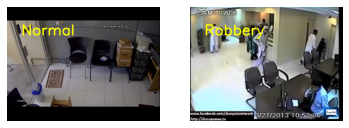

In [10]:
for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Data298b_robbery/Training/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Data298b_robbery/Training/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    
    plt.subplot(1, 2, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [11]:
SEQUENCE_LENGTH = 21

IMAGE_HEIGHT= 180

IMAGE_WIDTH= 180

DATASET_DIR = r"/content/drive/MyDrive/Data298b_robbery/Training/"

CLASSES_LIST = ["Normal","Robbery"]  

In [12]:
def frames_extraction(video_path):

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterating through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

In [13]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [14]:
features, labels, video_files_paths=create_dataset()

Extracting Data of Class: Normal
Extracting Data of Class: Robbery


Pickling

In [15]:
# creating pickle file to save the extracted features
import pickle
import os

pickle.dump(features,open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResnetv2_features.dat","wb"), protocol=4)
pickle.dump(labels,open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResnetv2_labels.dat","wb"), protocol=4)
pickle.dump(video_files_paths,open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResnetv2_video_files_paths.dat","wb"), protocol=4)

In [16]:
features=pickle.load(open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResnetv2_features.dat","rb"))
labels=pickle.load(open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResnetv2_labels.dat","rb"))
video_files_paths=pickle.load(open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResnetv2_video_files_paths.dat","rb"))

In [17]:
one_hot_encoded_labels = to_categorical(labels)

In [18]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,test_size = 0.2, shuffle = True,random_state = seed_constant)

In [21]:
from tensorflow.keras import optimizers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, LSTM,  Flatten, TimeDistributed, Conv2D, Dropout,Activation
from keras import Sequential
from keras.models import Model
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import regularizers

inceptionResnetV3 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for layer in inceptionResnetV3.layers:
    layer.trainable = False

In [77]:
def create_inceptionResnetV3_LSTM_model():

    model= Sequential()     
  
    model.add(TimeDistributed(inceptionResnetV3, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(Dense(512, activation="relu",))

    model.add(TimeDistributed(Dropout(0.3)))

    model.add(Dense(256, activation="relu",))

    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(Dense(128, activation="relu"))

    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(Dense(64, activation="relu"))

    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(Dense(32, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)))

    model.add(TimeDistributed(Dropout(0.3)))

    model.add(Dense(16, activation="relu"))

    model.add(TimeDistributed(Dropout(0.3)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32, activation='relu', return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))

    return model

In [78]:
inceptionResnetV3_model = create_inceptionResnetV3_LSTM_model()

In [79]:
inceptionResnetV3_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_56 (TimeDi  (None, 21, 4, 4, 1536)   54336736  
 stributed)                                                      
                                                                 
 dense_48 (Dense)            (None, 21, 4, 4, 512)     786944    
                                                                 
 time_distributed_57 (TimeDi  (None, 21, 4, 4, 512)    0         
 stributed)                                                      
                                                                 
 dense_49 (Dense)            (None, 21, 4, 4, 256)     131328    
                                                                 
 time_distributed_58 (TimeDi  (None, 21, 4, 4, 256)    0         
 stributed)                                                      
                                                      

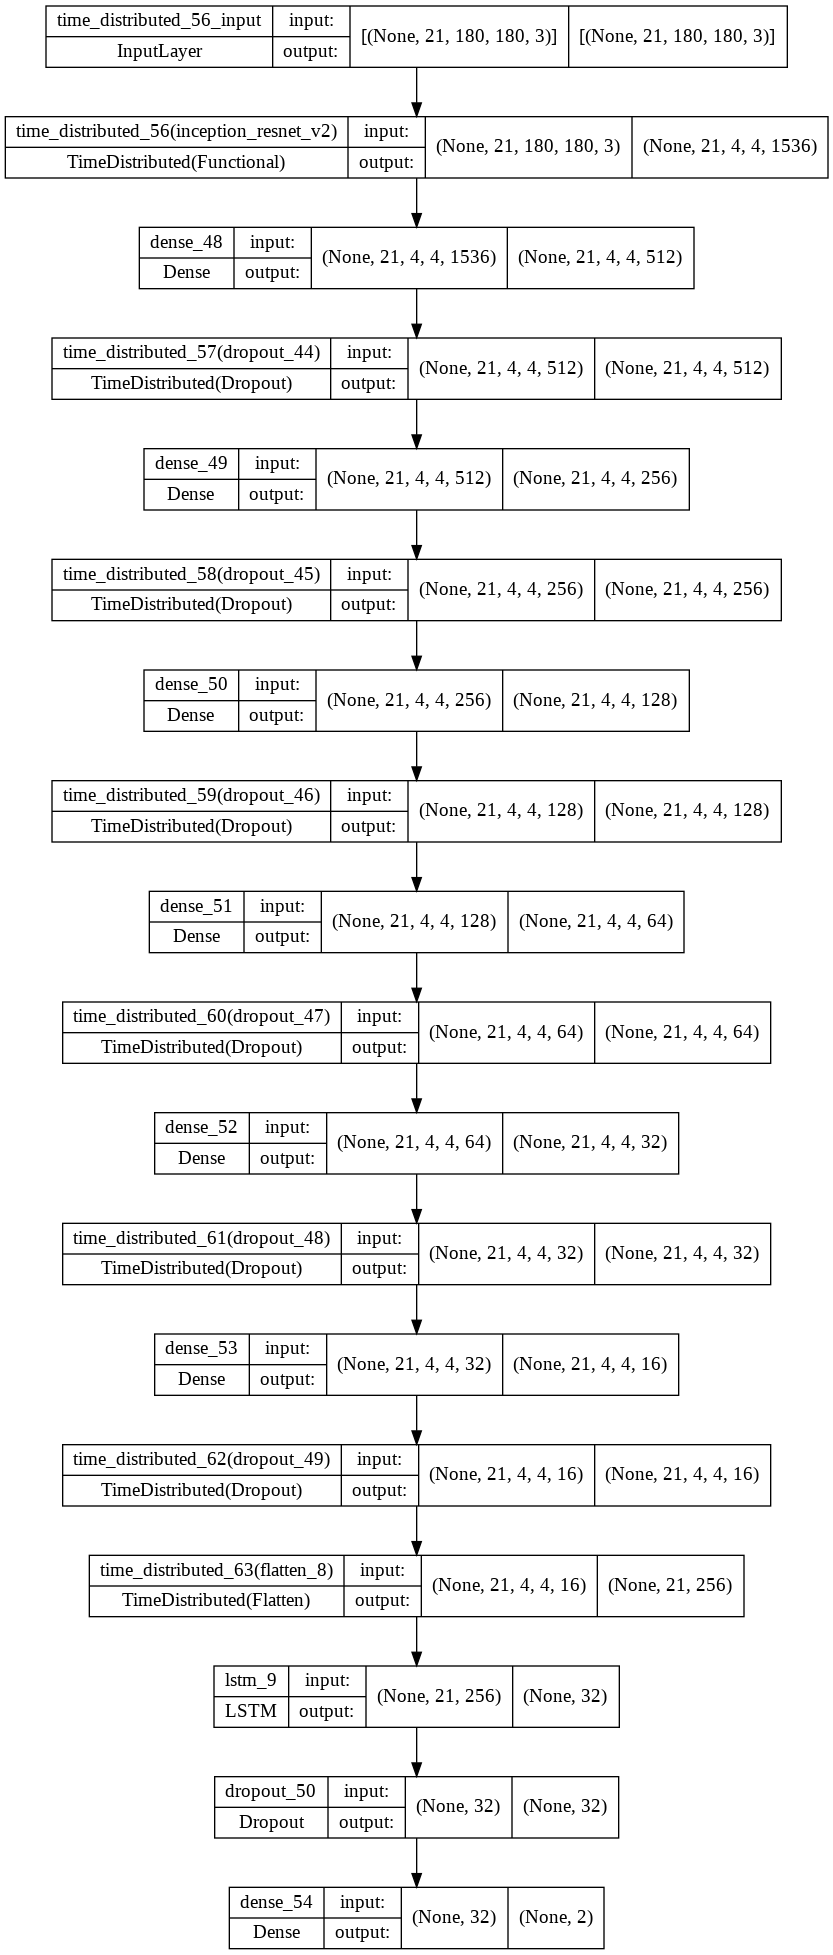

In [80]:
# Plot the structure of the ConvLSTM model.
plot_model(inceptionResnetV3_model, to_file = '/content/drive/MyDrive/Data298b_robbery/constructed_model/inceptionResnetV3_model_structure.png', show_shapes = True, show_layer_names = True)

In [81]:
# compile the model
optim = Adam(lr=1e-3, decay=1e-3 / 25)
inceptionResnetV3_model.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])

In [82]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Start training the model.
inceptionResnetV3_training_history = inceptionResnetV3_model.fit(x = features_train, y = labels_train, epochs = 40, batch_size = 10 ,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/40
20/20 [==============================] - 37s 865ms/step - loss: 0.8092 - accuracy: 0.4740 - val_loss: 0.7331 - val_accuracy: 0.6531
Epoch 2/40
20/20 [==============================] - 9s 468ms/step - loss: 0.7718 - accuracy: 0.5104 - val_loss: 0.7349 - val_accuracy: 0.6327
Epoch 3/40
20/20 [==============================] - 9s 467ms/step - loss: 0.7551 - accuracy: 0.5260 - val_loss: 0.7367 - val_accuracy: 0.5306
Epoch 4/40
20/20 [==============================] - 9s 468ms/step - loss: 0.7431 - accuracy: 0.5208 - val_loss: 0.7403 - val_accuracy: 0.4898
Epoch 5/40
20/20 [==============================] - 10s 491ms/step - loss: 0.7359 - accuracy: 0.5260 - val_loss: 0.7323 - val_accuracy: 0.5102
Epoch 6/40
20/20 [==============================] - 10s 490ms/step - loss: 0.7217 - accuracy: 0.5573 - val_loss: 0.7248 - val_accuracy: 0.5510
Epoch 7/40
20/20 [==============================] - 10s 489ms/step - loss: 0.7216 - accuracy: 0.5573 - val_loss: 0.7208 - val_accuracy: 0.5306
Ep

In [85]:
# Evaluate the trained model.
inceptionResnetV3_test_history = inceptionResnetV3_model.evaluate(features_test, labels_test)

2/2 [==============================] - 2s 909ms/step - loss: 0.6232 - accuracy: 0.8361


In [86]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

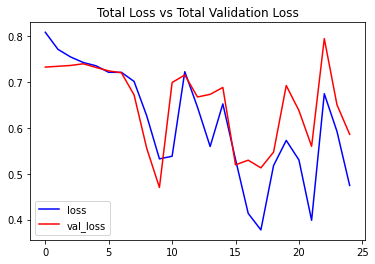

In [87]:

# Visualizing the training and validation loss metrices.
plot_metric(inceptionResnetV3_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


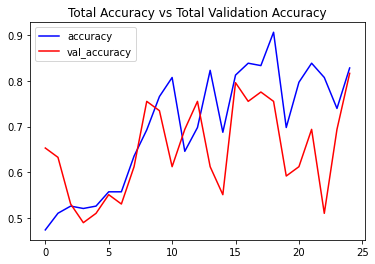

In [88]:
# Visualizing the training and validation accuracy metrices.
plot_metric(inceptionResnetV3_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Test on new unseen video


In [ ]:
test_videos_directory = f'/content/drive/MyDrive/Data298b_robbery/Testing/Test_output'
os.makedirs(test_videos_directory, exist_ok = True)

input_video_file_path = f'/content/drive/MyDrive/Data298b_robbery/Testing/test_robbery003.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = inceptionResnetV3_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/test_robbery022_output.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()